In [72]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

import sys
sys.path.append("../src")

from environments.takeaway.utils import all_arguments, show_ranking_by_taker, get_global_values, argument_types
from argumentation.utils import text_to_values, values_to_ranking

In [73]:
def extract_termination_conditions(path):
    data = pd.read_csv(path, comment='#', header=None, sep='\t')
    termination_conditions = data.iloc[:,4]
    return termination_conditions

def extract_durations(path):
    termination_conditions = extract_termination_conditions(path)
    data = pd.read_csv(path, comment='#', header=None, sep='\t')
    durations = data.iloc[:,3] / 10        # convert to seconds
    durations = durations + (termination_conditions=='w')*20
    return durations

def compute_durations(path, printing=True, prefix = "", last=0):
    durations = extract_durations(path)
    if last > 0:
        durations = durations[-last:]
    dur_mean, dur_se = compute_mean_s(durations)
    if printing:
        print(prefix, round(dur_mean, 2), "±" , round(dur_se, 2), "s")
    return dur_mean, dur_se

def compute_mean_s(data, se=True):
    data = np.array(data)
    mean = data.mean()
    s = data.std()
    if se:
        s /= math.sqrt(len(data))
    return mean, s


def plot_durations(path, window_size=25):
    durations = extract_durations(path)
    durations = durations.rolling(window_size).mean()
    plt.plot(durations)

def hist_durations(path):
    durations = extract_durations(path)
    plt.hist(durations)

### Performance metric
These are the perfromance metrics (i.e., the match durations in Takeaway) for each model for the logs obtained by playing with each model for 1000 episodes on a Takeaway field of sizes 30x30, 40x40 and 60x60.

In [74]:
# Uncomment the field size to analyze:
# field_size = "30x30"
field_size = "40x40"
# field_size = "60x60"

prefix = f"./match_logs/{field_size}"
print(field_size)

hand_path = f"{prefix}/handcrafted.kwy"
hand_mean, hand_se = compute_durations(hand_path, prefix="    Handcrafted:")

exp_path = f"{prefix}/expert.kwy"
exp_mean, exp_se = compute_durations(exp_path, prefix="    Expert:")

sarsa_path = f"{prefix}/sarsa.kwy"
sarsa_mean, sarsa_se = compute_durations(sarsa_path, prefix="    SARSA:")

ext_path = f"{prefix}/extracted.kwy"
ext_mean, ext_se = compute_durations(ext_path, prefix="    Extracted:")
# Fidelity score wrt sarsa (measured on 40x40):
# Agent 1 matchRatio: 99.0248
# Agent 2 matchRatio: 41.3613
# Agent 3 matchRatio: 96.9697

orla_loc_path = f"{prefix}/orla_local.kwy"
orla_loc_mean, orla_loc_se = compute_durations(orla_loc_path, prefix="    ORLA local:")
# Fidelity score wrt sarsa (measured on 40x40):
# Agent 1 matchRatio: 13.0118
# Agent 2 matchRatio: 20.3883
# Agent 3 matchRatio: 57.3828

orla_glob_path = f"{prefix}/orla_global.kwy"
orla_glob_mean, orla_glob_se = compute_durations(orla_glob_path, prefix="    ORLA global:")
# Fidelity score wrt sarsa (measured on 40x40):
# Agent 1 matchRatio: 16.0994
# Agent 2 matchRatio: 62.234
# Agent 3 matchRatio: 13.4942


40x40
    Handcrafted: 13.32 ± 0.29 s
    Expert: 9.68 ± 0.15 s
    SARSA: 9.14 ± 0.17 s
    Extracted: 12.16 ± 0.29 s
    ORLA local: 9.23 ± 0.15 s
    ORLA global: 9.44 ± 0.16 s


## Visual comparison of the distributions
This is just to have a better feel of what the above distributions look really like.

FIELD SIZE: 40x40


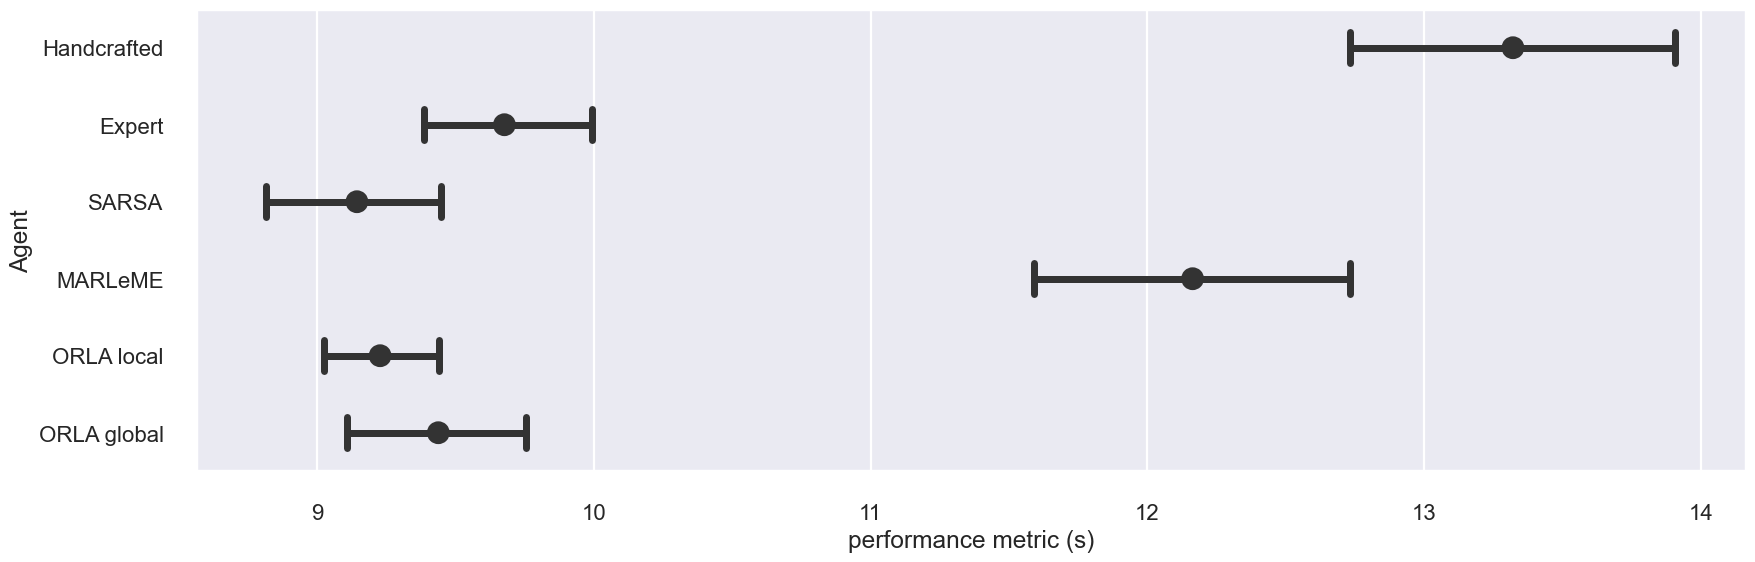

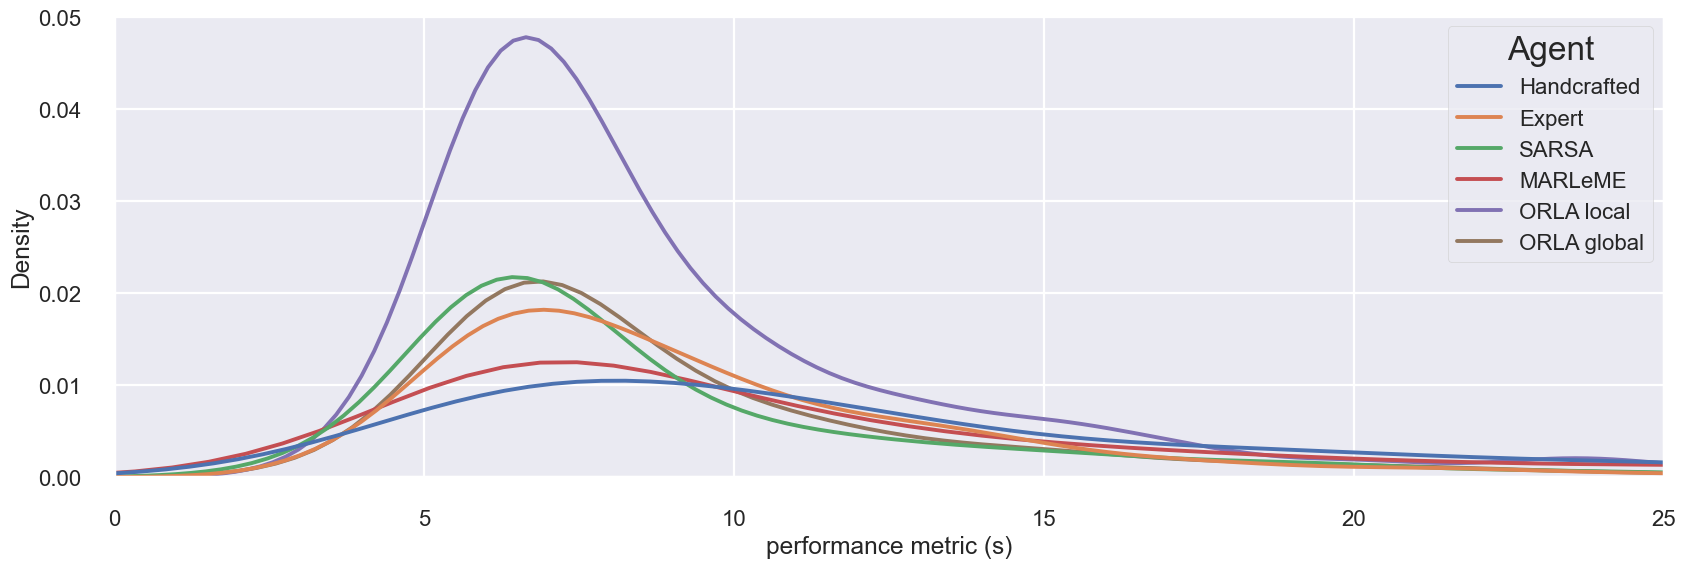

In [75]:
print(f"FIELD SIZE: {field_size}")


df_hand = pd.DataFrame(extract_durations(hand_path))
df_hand.columns = ['performance metric (s)']
df_hand['Agent'] = 'Handcrafted'

df_exp = pd.DataFrame(extract_durations(exp_path))
df_exp.columns = ['performance metric (s)']
df_exp['Agent'] = 'Expert'

df_orig = pd.DataFrame(extract_durations(sarsa_path))
df_orig.columns = ['performance metric (s)']
df_orig['Agent'] = 'SARSA'

df_ext = pd.DataFrame(extract_durations(ext_path))
df_ext.columns = ['performance metric (s)']
df_ext['Agent'] = 'MARLeME'

df_orla_loc = pd.DataFrame(extract_durations(orla_loc_path))
df_orla_loc.columns = ['performance metric (s)']
df_orla_loc['Agent'] = 'ORLA local'

df_orla_glob = pd.DataFrame(extract_durations(orla_glob_path))
df_orla_glob.columns = ['performance metric (s)']
df_orla_glob['Agent'] = 'ORLA global'

dfs = [df_hand, df_exp, df_orig, df_ext, df_orla_loc, df_orla_loc, df_orla_glob]

df = pd.concat(dfs, ignore_index=True )

plt.style.use('seaborn-poster')
plt.rcParams["figure.figsize"] = (20,6)

sns.pointplot(
    data=df, x="performance metric (s)", y="Agent",
    errorbar=("se" ), capsize=.4, join=False, color=".2",
)

plt.show()

sns.kdeplot(data=df, x="performance metric (s)", hue="Agent")
plt.xlim(0,25)
plt.show()


## Ranking of arguments
This shows the ranking or arguments for each VAF-based model grouping arguments by taker.

In [57]:
suffixes = ["extracted", "orla_local", "orla_global"]
for suffix in suffixes:
    print(suffix)
    path_ranking = f"./rankings/{suffix}.txt"
    arg_val = text_to_values(path_ranking, all_arguments)
    ranking = values_to_ranking(arg_val)
    show_ranking_by_taker(ranking)
# print("Full ranking:")
# filter_ranking(path_ranking, all_arguments)

extracted
    T1:  [['OpenKeeper1,4'], ['MinAngle1,4'], ['MinDist1,4'], ['FarKeeper1,4'], ['TackleBall1'], ['MinDist1,2'], ['MinAngle1,2'], ['OpenKeeper1,2'], ['FarKeeper1,2'], ['MinAngle1,3'], ['MinDist1,3'], ['OpenKeeper1,3'], ['FarKeeper1,3']]
    T2:  [['TackleBall2'], ['MinAngle2,3'], ['MinDist2,3'], ['FarKeeper2,3'], ['MinAngle2,4'], ['OpenKeeper2,3'], ['MinDist2,4'], ['MinAngle2,2'], ['MinDist2,2'], ['OpenKeeper2,2'], ['OpenKeeper2,4'], ['FarKeeper2,2'], ['FarKeeper2,4']]
    T3:  [['OpenKeeper3,3'], ['MinAngle3,3'], ['MinDist3,3'], ['FarKeeper3,3'], ['TackleBall3'], ['MinAngle3,4'], ['MinDist3,4'], ['OpenKeeper3,4'], ['FarKeeper3,4'], ['MinAngle3,2'], ['MinDist3,2'], ['OpenKeeper3,2'], ['FarKeeper3,2']]
orla_local
    T1:  [['TackleBall1'], ['MinAngle1,2'], ['MinDist1,2'], ['MinDist1,3'], ['OpenKeeper1,4'], ['OpenKeeper1,3'], ['FarKeeper1,4'], ['MinDist1,4'], ['FarKeeper1,2'], ['MinAngle1,3'], ['MinAngle1,4'], ['OpenKeeper1,2'], ['FarKeeper1,3']]
    T2:  [['TackleBall2'], ['Op

## ORLA global
This shows the actual value of the arguments learned by $\texttt{M}_\text{glob}$:

In [59]:
# Raw strict ORLA global ranking you want to pass (see markdown above).
path_ranking = "./rankings/orla_global.txt"
arg_val = text_to_values(path_ranking, all_arguments)
global_values = dict()
for arg_type in argument_types:
    for arg in arg_val:
        if str(arg).startswith(arg_type):
            global_values[arg_type] = arg_val[arg]
            break
sorted(global_values.items(), key=lambda x:x[1], reverse=True)

[('TackleBall', 36),
 ('MinAngle', 25),
 ('MinDist', 23),
 ('OpenKeeper', 14),
 ('FarKeeper', 12)]